# Fire Hazard Incidents Analytics Pipeline

## Importing Required Libraries

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from storedb import save_in_db, IMG_PATH
import matplotlib.pyplot as plt

## Creating Spark Session and using all available cores

In [6]:
spark = SparkSession \
    .builder \
    .appName("532: Project") \
    .config("local[4]") \
    .getOrCreate()

22/12/11 20:58:57 WARN Utils: Your hostname, Janhvis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.109 instead (on interface en0)
22/12/11 20:58:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/11 20:58:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/11 20:58:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/12/11 20:58:58 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/12/11 20:58:58 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/12/11 20:58:58 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
22/12/11 20:58:58 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
22/12/11 20:58:58 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.


## Loading civilian casuality, firefighter casuality, fire incidents and basic module data

In [12]:
civilian_casualities_df = spark.read.options(delimiter="^", header=True).csv("civiliancasualty.txt")
firefighter_casualities_df = spark.read.options(delimiter="^", header=True).csv("ffcasualty.txt")
basic_module_df = spark.read.options(delimiter="^", header=True).csv("basicincident.txt")
fire_incidents_df = spark.read.options(delimiter="^", header=True).csv("fireincident.txt")

In [8]:
# Dropping null values in loss tables and finding total loss
basic_module_df = basic_module_df.na.drop(subset=("PROP_LOSS","CONT_LOSS"))
total_loss = basic_module_df.groupBy("INCIDENT_KEY").agg(F.sum(basic_module_df.PROP_LOSS + basic_module_df.CONT_LOSS).alias("TOTAL_LOSS"))

In [9]:
# Finding Civilian Injury Severity vs. Dollar Loss
civilian_dollar_loss = total_loss.join(civilian_casualities_df, total_loss.INCIDENT_KEY == civilian_casualities_df.INCIDENT_KEY)
cdl_df = civilian_dollar_loss.groupBy("SEV").agg(F.avg("TOTAL_LOSS").alias("AVG_LOSS"))
p_cdl_df = cdl_df.toPandas()
p_cdl_df["AVG_LOSS"] = p_cdl_df["AVG_LOSS"]/1000

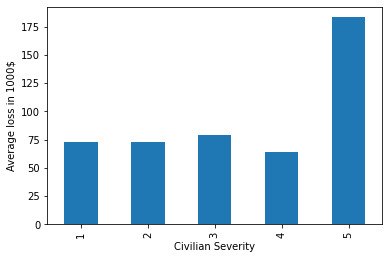

In [12]:
p1 = p_cdl_df.drop([2]).sort_values(by="SEV").plot(x="SEV", y="AVG_LOSS", xlabel="Civilian Severity", ylabel = "Average loss in 1000$", kind="bar", legend = False)
fig1 = p1.get_figure()
fig1.savefig(f"{IMG_PATH}civilian_dollar_loss.png")
save_in_db("civilian_dollar_loss.png", "p1")

In [102]:
# Finding Firefighter Injury Severity vs. Dollar Loss
firefighter_dollar_loss = total_loss.join(firefighter_casualities_df, total_loss.INCIDENT_KEY == firefighter_casualities_df.INCIDENT_KEY)
ffdl_df = firefighter_dollar_loss.groupBy("SEVERITY").agg(F.avg("TOTAL_LOSS").alias("AVG_LOSS"))
p_ffdl_df = ffdl_df.toPandas()

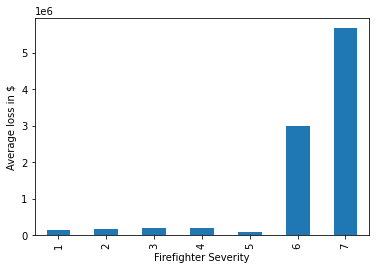

In [103]:
p2 = p_ffdl_df.drop([3]).sort_values(by="SEVERITY").plot(x="SEVERITY", y="AVG_LOSS", xlabel="Firefighter Severity", ylabel = "Average loss in $", kind="bar", legend = False)
fig2 = p2.get_figure()
fig2.savefig("ff_dollar_loss.png")

In [105]:
# Formatting datetime columns
basic_time_module_df = basic_module_df.withColumn("ALARM_TIME", F.to_timestamp("ALARM","MMddyyyyHHmm")).withColumn("CONT_TIME", F.to_timestamp("INC_CONT","MMddyyyyHHmm")).withColumn("ARV_TIME", F.to_timestamp("ARRIVAL","MMddyyyyHHmm"))

In [106]:
# Finding Civilian Casualty vs. Total Fire Time(in seconds)
total_fire_time_df = basic_time_module_df.withColumn("TOTAL_FIRE_TIME", basic_time_module_df.CONT_TIME.cast("long") - basic_time_module_df.ALARM_TIME.cast("long"))
civilian_casualty_fire_time = total_fire_time_df.join(civilian_casualities_df, total_fire_time_df.INCIDENT_KEY == civilian_casualities_df.INCIDENT_KEY)
ccft_df = civilian_casualty_fire_time.groupBy("SEV").agg(F.avg("TOTAL_FIRE_TIME").alias("AVG_FIRE_TIME"))
p_ccft_df = ccft_df.toPandas()
p_ccft_df["AVG_FIRE_TIME"] = p_ccft_df["AVG_FIRE_TIME"]/60

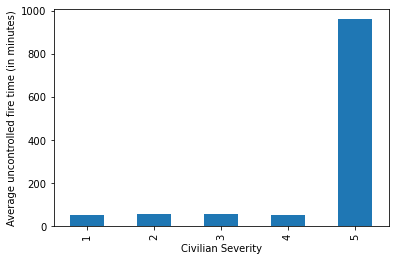

In [107]:
p3 = p_ccft_df.drop([2]).sort_values(by="SEV").plot(x="SEV", y="AVG_FIRE_TIME", xlabel="Civilian Severity", ylabel = "Average uncontrolled fire time (in minutes)", kind="bar", legend = False)
fig3 = p3.get_figure()
fig3.savefig("civ_fire_time.png")

In [108]:
ff_response_time = basic_time_module_df.withColumn("FF_RESPONSE_TIME", basic_time_module_df.CONT_TIME.cast("long") - basic_time_module_df.ARV_TIME.cast("long"))
ff_severity_response_time = ff_response_time.join(firefighter_casualities_df, ff_response_time.INCIDENT_KEY == firefighter_casualities_df.INCIDENT_KEY)
ffrt_df = ff_severity_response_time.groupBy("SEVERITY").agg(F.avg("FF_RESPONSE_TIME").alias("AVG_RSP_TIME"))
p_ffrt_df = ffrt_df.toPandas()
p_ffrt_df["AVG_RSP_TIME"] = p_ffrt_df["AVG_RSP_TIME"]/3600

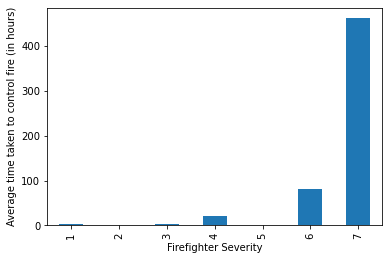

In [109]:
p4 = p_ffrt_df.drop([3]).sort_values(by="SEVERITY").plot(x="SEVERITY", y="AVG_RSP_TIME", xlabel="Firefighter Severity", ylabel = "Average time taken to control fire (in hours)", kind="bar", legend = False)
fig4 = p4.get_figure()
fig4.savefig("ff_fire_time.png")

In [191]:
ignition_cause = fire_incidents_df.na.drop(subset=("CAUSE_IGN"))

In [111]:
ignition_cause_vs_loss = total_loss.join(ignition_cause, total_loss.INCIDENT_KEY == ignition_cause.INCIDENT_KEY)
cause_loss_df = ignition_cause_vs_loss.groupBy("CAUSE_IGN").agg(F.sum("TOTAL_LOSS").alias("DLR_LOSS"))
p_cause_loss_df = cause_loss_df.toPandas()
p_cause_loss_df["DLR_LOSS"] = p_cause_loss_df["DLR_LOSS"]/1e09

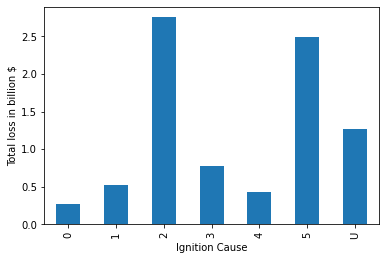

In [112]:
p5 = p_cause_loss_df.sort_values(by="CAUSE_IGN").plot(x="CAUSE_IGN", y="DLR_LOSS", xlabel="Ignition Cause", ylabel = "Total loss in billion $", kind="bar", legend = False)
fig5 = p5.get_figure()
fig5.savefig("cause_dollar_loss.png")

# Month vs Major states vs Types of fire

In [13]:
incident_state = basic_module_df.select("INCIDENT_KEY", "STATE", "INC_DATE")
incident_state.groupBy('STATE').count().sort(F.desc("count")).show()

# selecting top 10 states
incident_state = incident_state.withColumn("INC_MONTH", F.month(F.to_date(incident_state.INC_DATE,"MMddyyyy")))

incidents_ca = incident_state.filter(incident_state.STATE == "CA").groupBy("INC_MONTH").count()
incidents_tx = incident_state.filter(incident_state.STATE == "TX").groupBy("INC_MONTH").count()
incidents_pa = incident_state.filter(incident_state.STATE == "PA").groupBy("INC_MONTH").count()
incidents_fl = incident_state.filter(incident_state.STATE == "FL").groupBy("INC_MONTH").count()
incidents_oh = incident_state.filter(incident_state.STATE == "OH").groupBy("INC_MONTH").count()
incidents_ny = incident_state.filter(incident_state.STATE == "NY").groupBy("INC_MONTH").count()
incidents_il = incident_state.filter(incident_state.STATE == "IL").groupBy("INC_MONTH").count()
incidents_ga = incident_state.filter(incident_state.STATE == "GA").groupBy("INC_MONTH").count()
incidents_nc = incident_state.filter(incident_state.STATE == "NC").groupBy("INC_MONTH").count()
incidents_mi = incident_state.filter(incident_state.STATE == "MI").groupBy("INC_MONTH").count()
incidents_ma = incident_state.filter(incident_state.STATE == "MA").groupBy("INC_MONTH").count()

# incidents_ca.show()
# incidents_tx.show()
# incidents_ma.show()

+-----+------+
|STATE| count|
+-----+------+
|   CA|199861|
|   NY|153107|
|   TX|147339|
|   PA|111974|
|   IL|108881|
|   OH|107875|
|   FL|103816|
|   MA| 87113|
|   MI| 81673|
|   NC| 71528|
|   GA| 69030|
|   WA| 56155|
|   NJ| 55601|
|   VA| 47907|
|   TN| 46844|
|   SC| 44756|
|   CO| 41844|
|   MO| 40311|
|   IN| 38287|
|   OK| 35816|
+-----+------+
only showing top 20 rows



In [14]:
inc_ca_df = incidents_ca.toPandas()
inc_tx_df = incidents_tx.toPandas()
inc_pa_df = incidents_pa.toPandas()
inc_fl_df = incidents_fl.toPandas()
inc_oh_df = incidents_oh.toPandas()
inc_ny_df = incidents_ny.toPandas()
inc_il_df = incidents_il.toPandas()
inc_ga_df = incidents_ga.toPandas()
inc_nc_df = incidents_nc.toPandas()
inc_mi_df = incidents_mi.toPandas()
inc_ma_df = incidents_ma.toPandas()

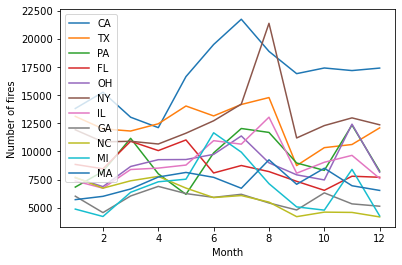

In [15]:
t1 = inc_ca_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count")
inc_tx_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_pa_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_fl_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_oh_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_ny_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_il_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_ga_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_nc_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_mi_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_ma_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", xlabel = "Month", ylabel = "Number of fires", ax = t1).get_figure()
plt.legend(["CA", "TX", "PA", "FL", "OH", "NY", "IL", "GA", "NC", "MI", "MA"])
plt.savefig("state_inc.png")

In [8]:
basic_module_df.select("OTH_INJ").distinct().show()
fire_incidents_df.select("NO_SPR_OP").distinct().show()
fire_incidents_df.select("ACRES_BURN").distinct().show()
fire_incidents_df.select("BLDG_INVOL").distinct().show()

+-------+
|OTH_INJ|
+-------+
|      7|
|      3|
|      0|
|   null|
|      1|
|      4|
|      2|
|      8|
|      5|
|      6|
|     10|
|     29|
|      9|
|     20|
|     12|
|     11|
+-------+




[Stage 11:=======>                                                  (1 + 7) / 8]



In [16]:
fire_incidents_df.select("NO_SPR_OP").count()

542192

In [31]:
fire_incidents_df.select("BLDG_INVOL").count()

542192

In [33]:
fire_incidents_df.select("NO_SPR_OP").count()
fire_incidents_df_na = fire_incidents_df.na.drop(subset=["NO_SPR_OP"])
fire_incidents_df_na.select("NO_SPR_OP").count()

5545

In [34]:
fire_incidents_df_na.select("NO_SPR_OP").distinct().show()

+---------+
|NO_SPR_OP|
+---------+
|        7|
|        3|
|        8|
|        0|
|        5|
|        6|
|       40|
|       25|
|        9|
|        1|
|       20|
|       10|
|        4|
|        2|
|      100|
|      150|
|      200|
|       60|
|       13|
|       45|
+---------+
only showing top 20 rows



In [35]:
fire_incidents_df_na.groupBy("NO_SPR_OP").count().show()

+---------+-----+
|NO_SPR_OP|count|
+---------+-----+
|        7|   12|
|        3|  162|
|        8|   19|
|        0| 1940|
|        5|   40|
|        6|   42|
|       40|    2|
|       25|    3|
|        9|    6|
|        1| 2594|
|       20|    6|
|       10|   30|
|        4|   94|
|        2|  559|
|      100|    8|
|      150|    2|
|      200|    1|
|       60|    1|
|       13|    1|
|       45|    1|
+---------+-----+
only showing top 20 rows



In [36]:
fire_incidents_df_na.select("ACRES_BURN").count()

5545

In [40]:
fire_incidents_df_na.groupBy("ACRES_BURN").count().show()

+----------+-----+
|ACRES_BURN|count|
+----------+-----+
|         0| 2415|
|      null| 3109|
|         1|   21|
+----------+-----+



In [39]:
fire_incidents_df_na.groupBy("BLDG_INVOL").count().show()

+----------+-----+
|BLDG_INVOL|count|
+----------+-----+
|         7|    1|
|         3|   12|
|         0|  701|
|      null|  901|
|         1| 3897|
|         2|   19|
|         4|    5|
|        12|    1|
|        14|    1|
|       160|    1|
|         8|    1|
|         5|    3|
|        18|    1|
|         6|    1|
+----------+-----+



In [113]:
wildlands_df.count()

69093

# Graph: Relative Humidity vs Spread Rate

In [114]:
wildlands_df_na = wildlands_df.na.drop(subset=("REL_HUMID","SPREAD_RAT"))
wildlands_df_na.count()

962

In [115]:
wildlands_df_na.groupBy("REL_HUMID").count().show()

+---------+-----+
|REL_HUMID|count|
+---------+-----+
|       15|   16|
|       29|   10|
|       42|    7|
|       64|    3|
|       30|   21|
|       34|    7|
|        8|    5|
|       28|    7|
|       85|    5|
|       35|   16|
|        0|  396|
|       43|    7|
|       31|    9|
|       18|   15|
|       70|   11|
|       75|    7|
|       17|   12|
|       26|    7|
|       46|    4|
|       78|    1|
+---------+-----+
only showing top 20 rows



In [120]:
wildlands_df_na.groupBy("SPREAD_RAT").count().show()

+----------+-----+
|SPREAD_RAT|count|
+----------+-----+
|        15|    7|
|         3|   22|
|         0|  684|
|         5|   14|
|        25|    4|
|         1|  115|
|        20|    7|
|        10|   12|
|         4|   16|
|        12|    3|
|         2|   43|
|        45|    1|
|        28|    1|
|        16|    1|
|         6|   13|
|        90|    1|
|       900|    1|
|        80|    1|
|         7|    2|
|         8|    6|
+----------+-----+
only showing top 20 rows



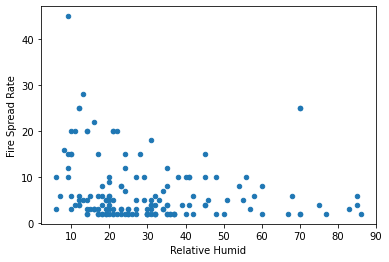

In [123]:
from pyspark.sql.types import IntegerType

wildlands_df_plot = wildlands_df_na.select("REL_HUMID", "SPREAD_RAT")

wildlands_df_plot = wildlands_df_plot.filter(wildlands_df_plot.SPREAD_RAT < 50).filter(wildlands_df_plot.SPREAD_RAT > 1)
p_wildlands_df_na = wildlands_df_plot.toPandas()
p_wildlands_df_na = p_wildlands_df_na.astype(float)
ptest = p_wildlands_df_na.sort_values(by="REL_HUMID").plot.scatter(x="REL_HUMID", y="SPREAD_RAT", xlabel="Relative Humid", ylabel = "Fire Spread Rate", legend = False)
figtest = ptest.get_figure()

# Graph: Spread Rate vs Fuel Moisture

In [210]:
wildlands_df_na = wildlands_df.na.drop(subset=("FUEL_MOIST","SPREAD_RAT"))
wildlands_df_na.count()

747

In [211]:
wildlands_df_na.groupBy("FUEL_MOIST").count().show()

+----------+-----+
|FUEL_MOIST|count|
+----------+-----+
|         7|    6|
|         3|    3|
|         8|    5|
|         0|  633|
|         5|   14|
|         6|    9|
|        25|    2|
|         1|    2|
|        12|    3|
|         2|    4|
|        15|   10|
|        18|    2|
|        75|    1|
|        60|    3|
|        68|    1|
|        84|    1|
|         9|    3|
|        20|    5|
|        10|   11|
|         4|    6|
+----------+-----+
only showing top 20 rows



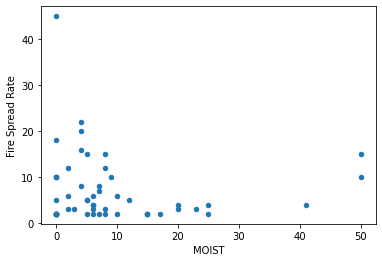

In [130]:
wildlands_df_plot = wildlands_df_na.select("FUEL_MOIST", "SPREAD_RAT")
wildlands_df_plot = wildlands_df_plot.filter(wildlands_df_plot.SPREAD_RAT < 50).filter(wildlands_df_plot.SPREAD_RAT > 1)
p_wildlands_df_na = wildlands_df_plot.toPandas()
p_wildlands_df_na = p_wildlands_df_na.astype(float)
ptest = p_wildlands_df_na.sort_values(by="FUEL_MOIST").plot.scatter(x="FUEL_MOIST", y="SPREAD_RAT", xlabel="MOIST", ylabel = "Fire Spread Rate", legend = False)
figtest = ptest.get_figure()

# Graph : Human Factors vs Count

In [139]:
ems_df = spark.read.options(delimiter="^", header=True).csv("ems.txt")
ems_df.count()

2031

In [204]:
ems_df_combine = ems_df.select(F.explode(F.array(ems_df.HUM_FACT1, ems_df.HUM_FACT2, ems_df.HUM_FACT3, ems_df.HUM_FACT4, ems_df.HUM_FACT5, ems_df.HUM_FACT6, ems_df.HUM_FACT7, ems_df.HUM_FACT8)).alias("HumanFactors"))
ems_df_comb_na = ems_df_combine.na.drop(subset=("HumanFactors"))

ems_df_comb_na = ems_df_comb_na.filter(ems_df_comb_na.HumanFactors != "N")
ems_df_comb_na = ems_df_comb_na.groupBy("HumanFactors").count()


In [205]:
p_ems_df = ems_df_comb_na.toPandas()
p_ems_df

,HumanFactors,count
0,3,26
1,8,10
2,5,14
3,6,16
4,1,20
5,4,26
6,2,6


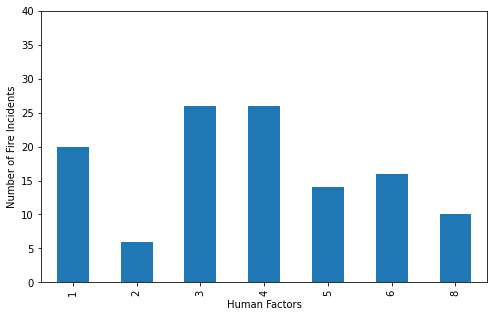

In [238]:
p_ems_df = ems_df_comb_na.toPandas()

# p_ems_df = p_ems_df.astype(float)
ptest = p_ems_df.sort_values(by="HumanFactors").plot(x="HumanFactors", y="count", xlabel="Human Factors", ylabel = "Number of Fire Incidents", legend = False, kind="bar", ylim=(0,40),figsize=(8,5))
fig1 = ptest.get_figure()
fig1.savefig("human_factors_number.png")

# Graph: Cause vs Count

In [192]:
ignition_cause.show()

+--------------------+-----+-----+--------+------+------+-------+--------+-------+----------+----------+----------+----------+---------+----------+---------+----------+---------+---------+----------+---------+---------+--------+---------+----------+----------+---------+---------+---------+---------+---------+---------+---------+---------+----+----+---------+---------+---------+---------+---------+--------+--------+-------------+--------+----------+---------+----------+--------+--------+---------+-------+--------+-------+---------+----------+----------+----------+----------+---------+----------+---------+---------+----------+----------+----------+----------+----------+---------+--------+--------+--------+---------+----------+----------+--------+--------+--------+--------+---------+--------+
|        INCIDENT_KEY|STATE| FDID|INC_DATE|INC_NO|EXP_NO|VERSION|NUM_UNIT|NOT_RES|BLDG_INVOL|ACRES_BURN|LESS_1ACRE|ON_SITE_M1|MAT_STOR1|ON_SITE_M2|MAT_STOR2|ON_SITE_M3|MAT_STOR3|AREA_ORIG|HEAT_SOURC|

In [193]:
ignition_cause = ignition_cause.groupBy("CAUSE_IGN").count()
ignition_cause.show()

+---------+------+
|CAUSE_IGN| count|
+---------+------+
|        3| 56107|
|        0|  8401|
|        5| 55852|
|        U|110306|
|        1| 67296|
|        4| 11135|
|        2|232727|
+---------+------+



In [224]:
p_ignition_cause = ignition_cause.toPandas()
p_ignition_cause["count"] = p_ignition_cause["count"]/1e03
# p_cause_loss_df["DLR_LOSS"]/1e05

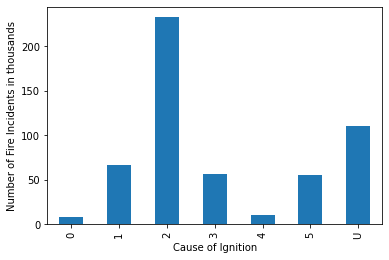

In [226]:
ptest = p_ignition_cause.sort_values(by="CAUSE_IGN").plot(x="CAUSE_IGN", y="count", xlabel="Cause of Ignition", ylabel = "Number of Fire Incidents in thousands", legend = False, kind="bar")
fig1 = ptest.get_figure()
fig1.savefig("cause_ignition_number.png")

In [4]:
save_in_db("fig1", "p1")